In [1]:
%pip install -r req.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1 # face detector and face recognition
from PIL import Image # python imaging library
import torch.nn.functional

/home/wtl04/coding/snapsend/computer_vision/venv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
img_path = "images/group1.jpg"
group_img = cv2.imread(img_path)
group_img = cv2.cvtColor(group_img, cv2.COLOR_BGR2RGB)

# Face Detection with MTCNN
---

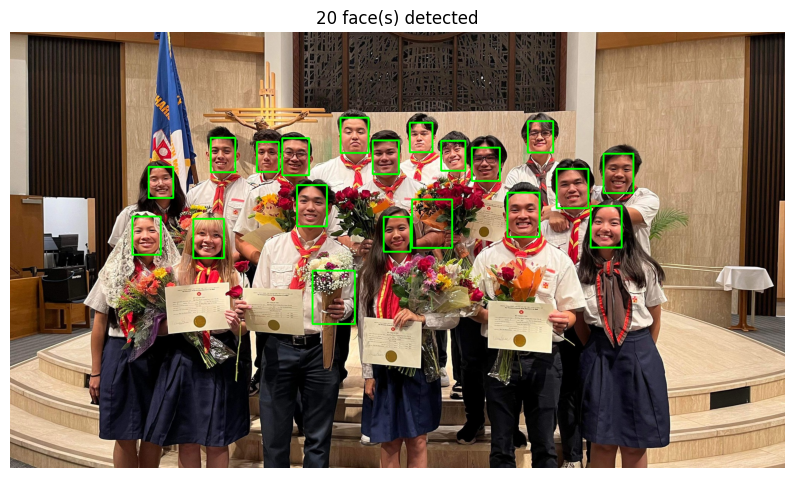

In [5]:
# Detect multiple faces
mtcnn_multi = MTCNN(keep_all=True) # turning mtcnn into detecting multiple faces
boxes, probs, landmarks = mtcnn_multi.detect(group_img, landmarks=True)

# Draw boxes
img_boxed = group_img.copy()

if boxes is not None:
    for box in boxes:
        x1, y1, x2, y2 = [int(b) for b in box]
        cv2.rectangle(img_boxed, (x1, y1), (x2, y2), color=(0,255,0), thickness=4)

# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(img_boxed)
plt.axis('off')
plt.title(f"{len(boxes)} face(s) detected" if boxes is not None else "No faces detected")
plt.show()

In [7]:
# Load image into a tensor
face_tensors = mtcnn_multi(group_img)

# Face Recognition with Inception Resnet (V1) 
---

In [8]:
mtcnn_single = MTCNN(keep_all=False) # turning mtcnn into detecting only single faces

In [9]:
resnet = InceptionResnetV1(pretrained='vggface2').eval() # initalize Resnet model

In [10]:
# Get 512D embeddings for all faces
# 512D because that is what InceptionResnetV1 is designed to output
group_embeddings = resnet(face_tensors)  # shape: (N, 512)

In [11]:
def cosine_sim(a, b):
    return torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

### Creating Database of Known Contacts

In [12]:
names = [
    "ailyn", "austin", "bdo", "ben", "bignate", "christina",
    "dylan", "jacob", "jhua", "john", "joseph", "kaitlyn", "kd",
    "marilyn", "peter", "theresa", "trin", "veronica", "will"
]

face_db = {}

for person_name in names:
    img = Image.open(f"images/headshots/{person_name}.jpeg")
    face = mtcnn_single(img)
    if face is not None:

        # reset takes 4D tensor input
        # we take the resulting embeddings and turn it back into 3D tensor
        emb = resnet(face.unsqueeze(0)).detach()
        face_db[person_name] = emb.squeeze(0)

### Testing Cosine Similarity with Singular New Face 

In [13]:
# import new face
new_img_path = "images/test_headshots/jhua_new.jpeg"
new_face = cv2.imread(new_img_path)
new_face = cv2.cvtColor(new_face, cv2.COLOR_BGR2RGB)

new_face_tensor = mtcnn_single(new_face)
new_emb = resnet(new_face_tensor.unsqueeze(0)).squeeze(0)

# score > 0.8 : likely the same person
# 0.6 <= score <= 0.8 : possilby the same person
# score < 0.6 : not the same person
scores = {}
for face in face_db:
    score = cosine_sim(new_emb, face_db[face])
    scores[face] = score

highest_score = float('-inf')
most_similar_face = ""
for face, score in scores.items():
    if score > highest_score:
        highest_score = score
        most_similar_face = face
    
print(f"most similar face: {most_similar_face} with a score of {highest_score}")

most similar face: jhua with a score of 0.8045069575309753


### Testing Cosine Similarity with Multiple Faces

In [14]:
# helper function for name visualization
def draw_label_with_background(img, text, x, y, font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.6, thickness=1):
    # Get text size
    (text_w, text_h), baseline = cv2.getTextSize(text, font, font_scale, thickness)

    # Define rectangle background coordinates
    rect_start = (x, y - text_h - 10)
    rect_end = (x + text_w + 4, y)

    # Draw filled green rectangle
    cv2.rectangle(img, rect_start, rect_end, (255, 0, 0), cv2.FILLED)

    # Put white text over it
    text_org = (x + 2, y - 5)
    cv2.putText(img, text, text_org, font, font_scale, (255, 255, 255), thickness)

In [15]:
img_draw = group_img.copy()

for i, (row, box) in enumerate(zip(group_embeddings, boxes)):

    # storing scores into dictionary
    # key : face
    # value : score
    scores = {}
    for face in face_db:
        score = cosine_sim(row, face_db[face])
        scores[face] = score

    # find best match
    most_similar_face = max(scores, key=scores.get)
    highest_score = scores[most_similar_face]

    if highest_score > 0.6:
        label = f"{most_similar_face} ({highest_score:.2f})"
    else:
        label = "Unknown"

    # draw bounding box
    x1, y1, x2, y2 = [int(coord) for coord in box]
    cv2.rectangle(img_draw, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    # draw label
    draw_label_with_background(img_draw, label, x1, y1, thickness=2)

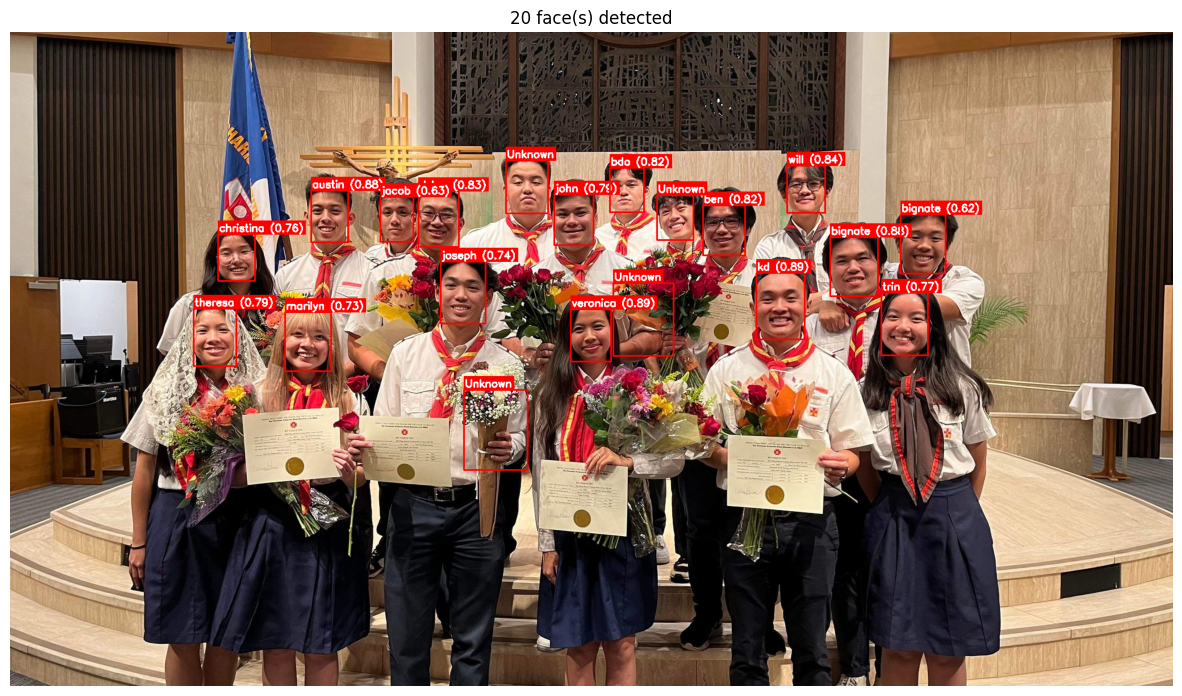

In [16]:
plt.figure(figsize=(15, 15))
plt.imshow(img_draw)
plt.axis('off')
plt.title(f"{len(boxes)} face(s) detected")
plt.show()